In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/faisal_exp

/content/drive/MyDrive/faisal_exp


In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
import pandas as pd
import numpy as np
X = pd.read_excel (r'/content/drive/MyDrive/faisal_exp/nir_specto.xlsx',header=None)
X = X.iloc[:,1:580] 
X=X[1:58]
X=np.array(X)
print(X.shape)


(57, 579)


In [ ]:
import pandas as pd
Y_p = pd.read_excel (r'/content/drive/MyDrive/faisal_exp/lab(%).xlsx')
Y_p = Y_p.iloc[:,1:8]
#Y_p = Y_p.iloc[:,2]
Y_p=np.array(Y_p)
print (Y_p.shape)


(57, 7)


In [ ]:
import pandas as pd
Y_c = pd.read_excel (r'/content/drive/MyDrive/faisal_exp/lab(content).xlsx')
Y_c = Y_c.iloc[:,2:9]
#Y_c = Y_c.iloc[:,2]
Y_c=np.array(Y_c)
print (Y_c.shape)



(57, 7)


In [ ]:
#Expand dataset, Function also available in ChemUtils
def dataaugment(x, betashift = 0.05, slopeshift = 0.05,multishift = 0.05):
    #Shift of baseline
    #calculate arrays
    beta = np.random.random(size=(x.shape[0],1))*2*betashift-betashift
    slope = np.random.random(size=(x.shape[0],1))*2*slopeshift-slopeshift + 1
    #Calculate relative position
    axis = np.array(range(x.shape[1]))/float(x.shape[1])
    #Calculate offset to be added
    offset = slope*(axis) + beta - axis - slope/2. + 0.5

    #Multiplicative
    multi = np.random.random(size=(x.shape[0],1))*2*multishift-multishift + 1

    x = multi*x + offset

    return x

In [ ]:
np.random.seed(0)

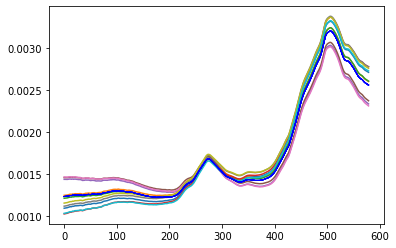

In [ ]:
#Data Augment a single spectrum
import numpy as np
from matplotlib import pyplot as plt
#First Spectrum
X_one = X[0:1]
#Repeating the spectrum 10x
X_one = np.repeat(X_one, repeats=10, axis=0)
#Augment (Large pertubations for illustration)
X_aug = dataaugment(X_one,betashift = 6.542472601263714e-05, slopeshift = 0.0005,multishift = 6.542472601263714e-05)
    
plt.plot(X_aug.T)
_= plt.plot(X_one.T, lw=1, c='b')

In [ ]:
shift = np.std(X)*0.1
shift

6.542472601263714e-05

570
570


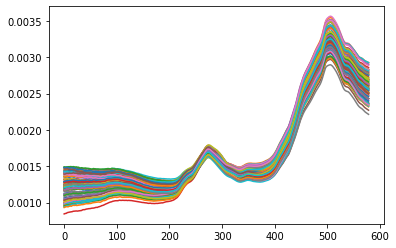

In [ ]:
X_train_aug = np.repeat(X, repeats=10, axis=0)
X_train_aug = dataaugment(X_train_aug, betashift = shift, slopeshift = 0.0005, multishift = shift)
# = s = np.random.normal(Y_mean, Y_std, 171)
y_train_aug = np.repeat(Y_p, repeats=10, axis=0) #y_train is simply repeated
#X_test_aug = np.repeat(X_test, repeats=10, axis=0)
#X_test_aug = dataaugment(X_test_aug, betashift = shift, slopeshift = 0.05, multishift = shift)

#y_test_aug = np.repeat(y_test, repeats=10, axis=0) #y_train is simply repeated


print (len(X_train_aug))
print (len(y_train_aug))
_ = plt.plot(X_train_aug[0:100].T)

In [ ]:
# Split the data into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_train_aug, y_train_aug, test_size=0.30, random_state=42)
 
# Quick sanity check with the shapes of Training and testing datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(399, 579)
(399, 7)
(171, 579)
(171, 7)


In [ ]:
# data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)
# fit scaler on training data
norm_lab = MinMaxScaler().fit(y_train)

# transform training data
X_train_norm = norm.transform(X_train)

# transform testing dataabs
X_test_norm = norm.transform(X_test)
# transform training label
Y_train_norm = norm_lab.transform(y_train)

# transform testing label
Y_test_norm = norm_lab.transform(y_test)

In [ ]:
#Rescale to NN friendly number range
from ChemUtils import GlobalStandardScaler

xscaler = GlobalStandardScaler()

#Calibrate is smaler than test, so they are swapped
X_train = xscaler.fit_transform(X_train) #From instrument 1
X_test=xscaler.transform(X_test)

In [ ]:
yscaler = GlobalStandardScaler()
y_train = yscaler.fit_transform( y_train)
y_test = yscaler.transform( y_test)  

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
model = Sequential()
model.add(Dense(20, input_dim=6, kernel_initializer='he_normal', activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, Reshape#, MaxPooling1D
from keras.callbacks import ReduceLROnPlateau
from keras.layers.noise import GaussianNoise
from keras.layers import LSTM
from keras.layers import BatchNormalization

In [ ]:
#Hyperparameters for the network
DENSE = 128
DROPOUT = 0.5
C1_K  = 8 #Number of kernels/feature extractors for first layer
C1_S  = 32 #Width of the convolutional mini networks
C2_K  = 16
C2_S  = 32

activation='relu'

input_dim = X_train.shape[1]

#The model
def make_model():
    model = Sequential()
    #Adding a bit of GaussianNoise also works as regularization
    model.add(GaussianNoise(0.05, input_shape=(input_dim,)))
    #First two is number of filter + kernel size
    model.add(Reshape((input_dim, 1)))
    model.add(Conv1D(C1_K, (C1_S), activation=activation, padding="same"))
    model.add(Conv1D(C2_K, (C2_S), padding="same", activation=activation))
    #model.add(BatchNormalization())
    #model.add(LSTM(50))
    model.add(Flatten())
    model.add(Dropout(DROPOUT))
    model.add(Dense(DENSE, activation=activation))
    model.add(Dense(7, activation='linear'))

    model.compile(loss='mse', optimizer=keras.optimizers.Adadelta(lr=0.01))#, metrics=['mean_absolute_error'])

    return model

In [ ]:
model = make_model()
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_4 (GaussianNo (None, 579)               0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 579, 1)            0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 579, 8)            264       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 579, 16)           4112      
_________________________________________________________________
flatten_4 (Flatten)          (None, 9264)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 9264)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)              

In [ ]:
model.compile(loss='mse', optimizer='adam', metrics=['mse','mae'])
from keras.callbacks import EarlyStopping
import keras
early_stopping_monitor = EarlyStopping( monitor='val_mse',patience=100,verbose=1)
m_check = keras.callbacks.ModelCheckpoint(filepath = './nir_model.h5',
                                          monitor='val_mse',
                                          save_best_only=True,
                                          mode='min',
                                          verbose=1 )

In [ ]:
history = model.fit(X_train_norm , Y_train_norm  , 
                 batch_size=16, validation_data=(X_test_norm ,Y_test_norm ),
                 epochs=1000,
                 verbose=1,
                 shuffle = True,
                 callbacks=[m_check,early_stopping_monitor]
                 )

Epoch 1/1000
25/25 [==============================] - 2s 41ms/step - loss: 0.1298 - mse: 0.1298 - mae: 0.2801 - val_loss: 0.0648 - val_mse: 0.0648 - val_mae: 0.2083

Epoch 00001: val_mse improved from inf to 0.06482, saving model to ./nir_model.h5
Epoch 2/1000
25/25 [==============================] - 1s 34ms/step - loss: 0.0580 - mse: 0.0580 - mae: 0.1945 - val_loss: 0.0540 - val_mse: 0.0540 - val_mae: 0.1873

Epoch 00002: val_mse improved from 0.06482 to 0.05404, saving model to ./nir_model.h5
Epoch 3/1000
25/25 [==============================] - 1s 35ms/step - loss: 0.0527 - mse: 0.0527 - mae: 0.1860 - val_loss: 0.0550 - val_mse: 0.0550 - val_mae: 0.1893

Epoch 00003: val_mse did not improve from 0.05404
Epoch 4/1000
25/25 [==============================] - 1s 34ms/step - loss: 0.0531 - mse: 0.0531 - mae: 0.1858 - val_loss: 0.0569 - val_mse: 0.0569 - val_mae: 0.1930

Epoch 00004: val_mse did not improve from 0.05404
Epoch 5/1000
25/25 [==============================] - 1s 34ms/step -

dict_keys(['loss', 'mse', 'mae', 'val_loss', 'val_mse', 'val_mae'])


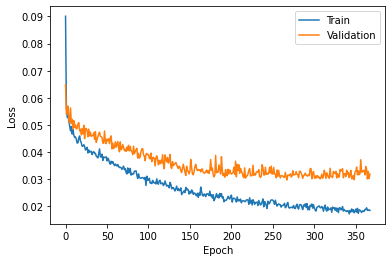

In [ ]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.savefig('cnn_loss.pdf',bbox_inches='tight')

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(Y_test_norm, model.predict(X_test_norm), multioutput='raw_values'))
print(r2_score(Y_train_norm, model.predict(X_train_norm),multioutput='raw_values'))

[0.68774946 0.30397144 0.40716534 0.45925381 0.46151845 0.41308409
 0.26320778]
[0.8251247  0.70248914 0.77763345 0.73911731 0.70954912 0.77799676
 0.77246496]


In [ ]:
y_train=norm_lab.inverse_transform(Y_train_norm)
y_test=norm_lab.inverse_transform(Y_test_norm)
y_pred1_train=model.predict(X_train_norm)
y_pred_train=norm_lab.inverse_transform(y_pred1_train)
y_pred1_test=model.predict(X_test_norm)
y_pred_test=norm_lab.inverse_transform(y_pred1_test)

In [ ]:
from sklearn.metrics import mean_squared_error
print(np.sqrt(mean_squared_error(y_test,y_pred_test ,multioutput='raw_values')))

[2.82367982 1.738614   0.88338927 2.51493766 1.31777503 2.37224204
 1.03295047]


In [ ]:
rmse_t=np.sqrt(mean_squared_error(y_train,y_pred_train ,multioutput='raw_values')) 
res = rmse_t.astype(np.float)
print(res)

[2.0856428  1.08184851 0.53177883 1.72338353 0.99270764 1.49438413
 0.5577723 ]


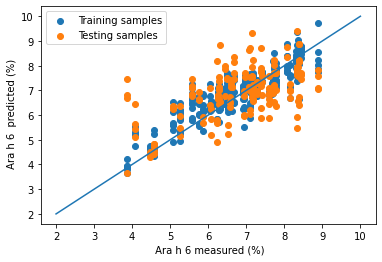

In [ ]:
fig = plt.figure(figsize=(6, 4))
plt.xlabel(" Ara h 6 measured (%)") 
plt.ylabel(" Ara h 6  predicted (%)") 
plt.scatter(y_train[:,6],y_pred_train[:,6])
plt.scatter(y_test[:,6], y_pred_test[:,6])
plt.legend(["Training samples", "Testing samples"], loc ="upper left") 
plt.plot([2,10],[2,10])  
plt.savefig('Ara h 6.pdf',bbox_inches='tight')

In [ ]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# This is our input image
input_img = keras.Input(shape=(579,))
# "encoded" is the encoded representation of the input
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = layers.Dense(579, activation='relu')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [ ]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [ ]:
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
def autoencoder_model():
    # This is the size of our encoded representations
    encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 float
    # This is our input image
    input_img = keras.Input(shape=(579,))
    # "encoded" is the encoded representation of the input
    encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(579, activation='relu')(encoded)

    #commonlayer

    #autoencoder
    # "decoded" is the lossy reconstruction of the input
    decoded = layers.Dense(579, activation='relu')(encoded)

    #regressor
    regress=layers.Dense(20,  activation='relu')(encoded)
    regress_out=layers.Dense(1, activation='linear')(regress)    


    model = keras.Model(inputs = input_img, outputs=[decoded,regress_out])
    model.compile(optimizer='adam', loss=['mse', 'mse'], metrics=["mse"])
    return model

In [ ]:
from keras.callbacks import EarlyStopping
model  =  autoencoder_model()
print(model.summary())
early_stopping_monitor = EarlyStopping( monitor='val_loss',patience=100,verbose=1)
m_check = keras.callbacks.ModelCheckpoint(filepath = './nir.h5',
                                          monitor='val_loss',
                                          save_best_only=True,
                                          mode='min',
                                          verbose=1 )

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 579)]        0                                            
__________________________________________________________________________________________________
dense_30 (Dense)                (None, 32)           18560       input_11[0][0]                   
__________________________________________________________________________________________________
dense_33 (Dense)                (None, 20)           660         dense_30[0][0]                   
__________________________________________________________________________________________________
dense_32 (Dense)                (None, 579)          19107       dense_30[0][0]                   
___________________________________________________________________________________________

In [ ]:
history = model.fit(X_train, [X_train,y_train ], 
                 batch_size= 32, validation_data=(X_test,[X_test,y_test]),
                 epochs=2000,
                 verbose=1,
                 shuffle = True,
                 callbacks=[m_check,early_stopping_monitor]
                )

Streaming output truncated to the last 5000 lines.
13/13 [==============================] - 0s 8ms/step - loss: 1.2678 - dense_32_loss: 0.3731 - dense_34_loss: 0.8947 - dense_32_mse: 0.3731 - dense_34_mse: 0.8947 - val_loss: 1.3954 - val_dense_32_loss: 0.3579 - val_dense_34_loss: 1.0375 - val_dense_32_mse: 0.3579 - val_dense_34_mse: 1.0375

Epoch 00108: val_loss did not improve from 1.33460
Epoch 109/2000
13/13 [==============================] - 0s 8ms/step - loss: 1.2969 - dense_32_loss: 0.3731 - dense_34_loss: 0.9238 - dense_32_mse: 0.3731 - dense_34_mse: 0.9238 - val_loss: 1.4369 - val_dense_32_loss: 0.3580 - val_dense_34_loss: 1.0790 - val_dense_32_mse: 0.3580 - val_dense_34_mse: 1.0790

Epoch 00109: val_loss did not improve from 1.33460
Epoch 110/2000
13/13 [==============================] - 0s 7ms/step - loss: 1.2952 - dense_32_loss: 0.3732 - dense_34_loss: 0.9220 - dense_32_mse: 0.3732 - dense_34_mse: 0.9220 - val_loss: 1.5241 - val_dense_32_loss: 0.3581 - val_dense_34_loss: 1.1

In [ ]:
print(autoencoder.summary())

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 579)]             0         
_________________________________________________________________
dense_8 (Dense)              (None, 32)                18560     
_________________________________________________________________
dense_9 (Dense)              (None, 579)               19107     
Total params: 37,667
Trainable params: 37,667
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=500,
                batch_size=64,
                shuffle=True,
                validation_data=(X_test, X_test))

Epoch 1/500
7/7 [==============================] - 1s 30ms/step - loss: 1.0208 - val_loss: 0.8992
Epoch 2/500
7/7 [==============================] - 0s 10ms/step - loss: 0.8937 - val_loss: 0.7774
Epoch 3/500
7/7 [==============================] - 0s 11ms/step - loss: 0.7723 - val_loss: 0.6491
Epoch 4/500
7/7 [==============================] - 0s 12ms/step - loss: 0.6463 - val_loss: 0.5540
Epoch 5/500
7/7 [==============================] - 0s 11ms/step - loss: 0.5577 - val_loss: 0.5054
Epoch 6/500
7/7 [==============================] - 0s 11ms/step - loss: 0.5184 - val_loss: 0.4848
Epoch 7/500
7/7 [==============================] - 0s 12ms/step - loss: 0.5028 - val_loss: 0.4761
Epoch 8/500
7/7 [==============================] - 0s 10ms/step - loss: 0.4902 - val_loss: 0.4723
Epoch 9/500
7/7 [==============================] - 0s 12ms/step - loss: 0.4913 - val_loss: 0.4706
Epoch 10/500
7/7 [==============================] - 0s 11ms/step - loss: 0.4864 - val_loss: 0.4700
Epoch 11/500
7/7 [=

In [ ]:
model = make_model()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_2 (GaussianNo (None, 579)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 579, 1)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 579, 8)            264       
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 579, 16)           4112      
_________________________________________________________________
lstm (LSTM)                  (None, 50)                13400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

In [ ]:
rdlr = ReduceLROnPlateau(patience=25, factor=0.5, min_lr=1e-6, monitor='val_loss', verbose=1)

h = model.fit(X_train, y_train, epochs=60, batch_size=32, validation_data=(X_test, y_test), callbacks=[rdlr])

Epoch 1/60
13/13 [==============================] - 7s 392ms/step - loss: 0.9225 - val_loss: 1.0409
Epoch 2/60
13/13 [==============================] - 5s 367ms/step - loss: 1.0992 - val_loss: 1.0391
Epoch 3/60
13/13 [==============================] - 5s 379ms/step - loss: 0.9585 - val_loss: 1.0381
Epoch 4/60
13/13 [==============================] - 5s 368ms/step - loss: 0.9078 - val_loss: 1.0371
Epoch 5/60
13/13 [==============================] - 5s 389ms/step - loss: 1.0142 - val_loss: 1.0363
Epoch 6/60
13/13 [==============================] - 5s 388ms/step - loss: 1.0841 - val_loss: 1.0352
Epoch 7/60
13/13 [==============================] - 5s 393ms/step - loss: 0.9872 - val_loss: 1.0343
Epoch 8/60
13/13 [==============================] - 5s 388ms/step - loss: 1.0321 - val_loss: 1.0334
Epoch 9/60
13/13 [==============================] - 5s 399ms/step - loss: 0.9345 - val_loss: 1.0323
Epoch 10/60
13/13 [==============================] - 5s 393ms/step - loss: 1.0516 - val_loss: 1.0313

KeyboardInterrupt: ignored

In [ ]:
from sklearn.metrics import r2_score
print(r2_score(y_test, pls2.predict(X_test)))
print(r2_score(y_train, pls2.predict(X_train)))

0.9065889180116107
0.9999999993801858


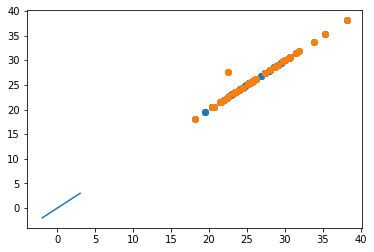

In [ ]:
plt.scatter(y_train, pls2.predict(X_train))
plt.scatter(y_test, pls2.predict(X_test))
plt.plot([-2,3],[-2,3])

In [ ]:
#Some metrics
def huber(y_true, y_pred, delta=1.0):
	y_true = y_true.reshape(-1,1)
	y_pred = y_pred.reshape(-1,1)
	return np.mean(delta**2*( (1+((y_true-y_pred)/delta)**2)**0.5 -1))

In [ ]:
def benchmark(X_train,y_train,X_test, y_test, model):
    rmse = np.mean((y_train - pls2.predict(X_train).reshape(y_train.shape))**2)**0.5
    rmse_test = np.mean((y_test - pls2.predict(X_test).reshape(y_test.shape))**2)**0.5
    hub = huber(y_train, pls2.predict(X_train))
    hub_test = huber(y_test, pls2.predict(X_test))
    print ("RMSE  Train/Test\t%0.2F\t%0.2F"%(rmse, rmse_test))
    print ("Huber Train/Test\t%0.4F\t%0.4F"%(hub, hub_test))

In [ ]:
benchmark(X_train, y_train, X_test, y_test, pls2)

RMSE  Train/Test	0.00	0.33
Huber Train/Test	0.0000	0.0397
